### Load data

In [1]:
import pickle
with open('splitData.pickle', 'rb') as f:
    texts_train = pickle.load(f)
    texts_val = pickle.load(f)
    texts_test = pickle.load(f)
    labels_train = pickle.load(f)
    labels_val = pickle.load(f)
    labels_test = pickle.load(f)

all_texts  = texts_train  + texts_val  + texts_test
all_labels = labels_train + labels_val + labels_test
# check the ratio of each dataset
total = len(texts_train) + len(texts_val) + len(texts_test)
len(texts_train)/total, len(texts_val)/total, len(texts_test)/total

(0.5997757847533632, 0.20011210762331838, 0.20011210762331838)

# Q2-Clustering

### Step 0: Vectorise text

## NOTE: lyrics are not necessarily limited to English

In [2]:
import spacy

nlp = spacy.load('en_core_web_sm') # can tokenize Spanish at least

added_stop_words = set(["ayy","ay","ah","oh","ohh","ooh","la","da","dum","ll","d","m","ve","yah","yeah"])
my_stop_words = nlp.Defaults.stop_words.union(added_stop_words)

# nlp = spacy.load("xx_ent_wiki_sm") <-not work well for lemmanize

def text_pipeline_spacy(text):
    tokens = []
    doc = nlp(text)
    for t in doc:
        if not t.is_stop and not t.is_punct and not t.is_space and not t in my_stop_words:
            tokens.append(t.lemma_.lower())
    return tokens

# Check pipiline:
text_pipeline_spacy("Of all the things I miss, I miss my mind the most.")

['thing', 'miss', 'miss', 'mind']

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer=text_pipeline_spacy, stop_words=my_stop_words)

texts_vector = vectorizer.fit_transform(all_texts)
texts_vector.shape

(1784, 19605)

## Conducting Kmeans

In [14]:
import numpy as np
np.random.seed(42)
def kmeans(k, matrix, max_iter=300):
    num_data, dim_feature = matrix.shape

    # Step1: pick k random centroids
    #### centroids = np.random.random([k,22406])  # Random Partition --- does not work well
    #Use Forgy partition to make sure at least one point is allocated to one point
    centroids = matrix[np.random.randint(0,num_data,k)]


    # new centroids to be calculated
    new_centroids = np.zeros((k,dim_feature))

    # labels(=index of centroids) assigned to data
    labels = np.zeros(num_data)

    # iterate until convergence or max_iteration
    for itr in range(max_iter):
        
        # iterate through all data
        for i in range(num_data):
            # matrix is a sparse vector, so make it dense array
            ith_vec = np.squeeze(np.asarray(matrix[i].todense()))

            #Step2: Assign each vector to its closest centroid
            dists = np.sum(np.square(centroids - ith_vec), axis=1)
            labels[i] = np.argmin(dists)

        #Step3:Recalculate the centroids
        for j in range(k):
            new_centroids[j] = matrix[labels==j].mean(axis=0)

        # If step 2 and 3 converges, exit for-loop         
        if np.all(new_centroids == centroids):
            print("converged")
            break;
        centroids = new_centroids

    return labels, new_centroids


clustered_labels, centroids = kmeans(5,texts_vector)
from collections import Counter
clustered_labels = [int(l) for l in clustered_labels]
Counter(clustered_labels)

converged


Counter({3: 885, 0: 750, 1: 81, 4: 62, 2: 6})

### For answering questions

In [15]:
# question a) show documents assigned to eatch cluster
shown = {} # labels checked
doc_samples = [[] for _ in range(5)]# documents sampled
for idx,l in enumerate(clustered_labels):
    if(shown.get(l,0) < 3):
        shown[l] = shown.get(l,0)+1
        doc_samples[l].append(all_texts[idx])
    
for label,docs in enumerate(doc_samples):
    print(f'\n=======label{label}=======')
    for i in range(3):
        print(f'{i}th docs')
        print(docs[i][:200])
        print('------------------')





=======label0=======
0th docs
Moonlight
Lyrics
The sun is setting and you're right here by my side
And the movie is playing, but we won't be watching tonight
Every look (Every look), every touch (Every touch)
Makes me wanna give y
------------------
1th docs
Shady XV
Shady XV Lyrics
I'm liable to start a violent spark with a silent thought
I disgust you like dialogue from The Shop to The Wired Frog
Night club, shit, I was taught
If your CD's on fire you h
------------------
2th docs
Bad Meets Evil
Meets Evil Lyrics
I reckon you ain't familiar with these here parts
You know, there's a story behind that there saloon
20 years ago, two outlaws took this whole town over
Sheriffs could
------------------

=======label1=======
0th docs
Write Your Name
Write Your Name Lyrics
Take my arm, take my head
Make your mark like a man
Write your name
Gonna write your name
Hurts so good, love and pain
When all fades, you remain
Write your name
------------------
1th docs
On the Floor (Mixin Marc & Tony

In [20]:
# question a)
for i in range(5):
    print(f"------top 5 tokens in centroid {i}-----")
    indices = np.argsort(centroids[i])[-15:] # indices of most prominent tokens
    for key,val in vectorizer.vocabulary_.items():
        if val in indices:
            print(f'{key}',end=",")
    print("\n")

# tokenizerを工夫したほうがよいかも

------top 5 tokens in centroid 0-----
to,in,the,you,my,up,your,it,me,like,that,and,we,on,of,

------top 5 tokens in centroid 1-----
oh,no,si,la,de,tu,se,en,el,lo,que,es,mi,amor,te,

------top 5 tokens in centroid 2-----
the,you,it,that,and,we,stay,harder,god,damn,la,glad,serious,effect,curious,

------top 5 tokens in centroid 3-----
to,the,you,my,be,your,it,love,me,that,can,oh,baby,and,ooh,

------top 5 tokens in centroid 4-----
to,in,the,you,my,it,for,me,that,can,and,of,she,her,da,



In [17]:
# question c) construct a confusion matrix
# correspond labels(songer names) with integers
label2id = {label: i for i, label in enumerate(set(labels_train))}
id2label = {id:label for label,id in label2id.items()}

print(Counter(clustered_labels))

cm = [[0 for _ in range(5)] for _ in range(10)]
for idx, label in enumerate(all_labels):
    true_id = label2id[label] 
    pred_id = clustered_labels[idx]
    cm[true_id][pred_id] += 1
cm = np.array(cm)
np.sum(cm,axis=0)

Counter({3: 885, 0: 750, 1: 81, 4: 62, 2: 6})


array([750,  81,   6, 885,  62])

In [18]:
a = list(label2id.keys())
labels_y = ['Eminem', 'Beyonce Knowles', 'Dua Lipa', 'Selena Gomez', 'Michael Jackson', 'Ariana Grande', 'Taylor Swift', 'Lady Gaga', 'XXXTentacion', 'Jennifer Lopez']
a == labels_y

False

<AxesSubplot:xlabel='k-means labels', ylabel='True labels'>

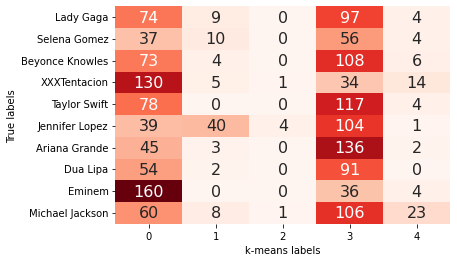

In [19]:
# show confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sn

def plotConfusionMatrix(cm, labels_val, labels_predicted):
  cm = cm
  colour_map = sn.color_palette("Reds", as_cmap=True)
  labels_x = labels_val
  labels_y = labels_predicted #list(label2id.keys())#['Eminem', 'Beyonce Knowles', 'Dua Lipa', 'Selena Gomez', 'Michael Jackson', 'Ariana Grande', 'Taylor Swift', 'Lady Gaga', 'XXXTentacion', 'Jennifer Lopez']
  plot = sn.heatmap(cm, 
                    annot=True, # Put the numbers in
                    annot_kws={"size": 16}, # Make the numbers bigger
                    fmt='g', # Stop scientific notation
                    cmap = colour_map, # Choose the colour palette
                    cbar = False, # Don't include the colour bar
                    xticklabels=labels_x,#labels_x, # Put in the X and Y labels
                    yticklabels=labels_y)
  plot.set(xlabel='k-means labels', ylabel='True labels')
  return plot

plotConfusionMatrix(cm, [str(i) for i in range(5)] ,list(label2id.keys()))

In [45]:
# unnecessary
from sklearn.cluster import KMeans
from collections import Counter
kmeans = KMeans(n_clusters=5, random_state=10).fit_predict(texts_vector)
Counter(kmeans)

/home/ryosuke/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Counter({4: 1092, 2: 199, 1: 86, 0: 308, 3: 99})

# Q3-Comparing Classifiers

In [14]:

# Show classifier performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def showPerformance(labels_true, labels_predicted):
    print(f'accuracy ={accuracy_score(labels_true, labels_predicted):.3f}')
    print(f'precision={precision_score(labels_true, labels_predicted, average="macro"):.3f}')
    print(f'recall   ={recall_score(labels_true, labels_predicted, average="macro"):.3f}') 
    print(f'f1       ={f1_score(labels_true, labels_predicted, average="macro"):.3f}')
    return ;


### Dummy Classifier with strategy="most_frequent"

In [15]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(texts_train,labels_train)
labels_predicted = dummy_clf.predict(texts_val)

print(dummy_clf.score(texts_val, labels_val))
showPerformance(labels_val, labels_predicted)

0.08403361344537816
accuracy =0.084
precision=0.008
recall   =0.100
f1       =0.016


/home/ryosuke/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Dummy Classifier with strategy="most_frequent"

In [16]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(texts_train,labels_train)
labels_predicted = dummy_clf.predict(texts_val)

# print(dummy_clf.score(texts_val, labels_val))
showPerformance(labels_val, labels_predicted)

accuracy =0.095
precision=0.098
recall   =0.092
f1       =0.094


### LogisticRegression with one-hot vectorization

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
vectorizer = CountVectorizer(tokenizer=text_pipeline_spacy)

vect_texts_train = vectorizer.fit_transform(texts_train)
vect_texts_train[vect_texts_train != 0] = 1 # convert non-zero counting into 1

vect_texts_val = vectorizer.transform(texts_val)
vect_texts_val[vect_texts_val != 0] = 1

# Logistic Regression
clf = LogisticRegression(random_state=42,max_iter=1000).fit(vect_texts_train, labels_train)
labels_predicted = clf.predict(vect_texts_val)


showPerformance(labels_val, labels_predicted)

/home/ryosuke/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


accuracy =0.563
precision=0.565
recall   =0.567
f1       =0.556


### LogisticRegression with TF-IDF vectorization

In [18]:
vectorizer = TfidfVectorizer(tokenizer=text_pipeline_spacy)
vect_texts_train = vectorizer.fit_transform(texts_train)
vect_texts_val = vectorizer.transform(texts_val)

# Logistic Regression
clf = LogisticRegression(random_state=42).fit(vect_texts_train, labels_train)
labels_predicted = clf.predict(vect_texts_val)


showPerformance(labels_val, labels_predicted)


/home/ryosuke/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


accuracy =0.451
precision=0.424
recall   =0.444
f1       =0.413


/home/ryosuke/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### SVC Classifier with One-hot vectorization

In [19]:
# making one-hot vectors
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(tokenizer=text_pipeline_spacy)
vect_texts_train = vectorizer.fit_transform(texts_train)
vect_texts_train[vect_texts_train != 0] = 1 # convert non-zero counting into 1

vect_texts_val = vectorizer.transform(texts_val)
vect_texts_val[vect_texts_val != 0] = 1

from sklearn.svm import SVC
clf = SVC(random_state=42).fit(vect_texts_train, labels_train)
labels_predicted = clf.predict(vect_texts_val)


showPerformance(labels_val, labels_predicted)

/home/ryosuke/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


accuracy =0.518
precision=0.498
recall   =0.514
f1       =0.481


/home/ryosuke/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Q4-Parameter Tuning

#### choose C value

In [20]:
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
param_C = {'C':np.logspace(-3,5,9,base=10.0)}

max_f1 = 0
best_param = {}
for params in tqdm(ParameterGrid(param_C)):
  # vectorize training set and validation set
  vectorizer = TfidfVectorizer()
  vect_texts_train = vectorizer.fit_transform(texts_train)
  vect_texts_val = vectorizer.transform(texts_val)

  # logistic regression
  clf = LogisticRegression(random_state=42,C=params['C'],max_iter=1000).fit(vect_texts_train, labels_train)
  labels_predicted = clf.predict(vect_texts_val)

  cur_f1 = f1_score(labels_val, labels_predicted,average="macro")
  if(cur_f1 > max_f1):
    max_f1 = cur_f1
    best_param = params

print(f'{best_param=}')
print(f'{max_f1:.3f}')



100%|██████████| 9/9 [01:42<00:00, 11.40s/it]

best_param={'C': 100.0}
0.504


#### choose vectorizer

In [21]:
param_vec = {'max_features':[None, 5, 50, 500, 5000, 50000], 'sublinear_tf':[True,False]}

max_f1 = 0
best_param = {}
for params in tqdm(ParameterGrid(param_vec)):
  # vectorize training set and validation set
  vectorizer = TfidfVectorizer(tokenizer=text_pipeline_spacy, max_features=params["max_features"], sublinear_tf=params["sublinear_tf"])
  vect_texts_train = vectorizer.fit_transform(texts_train)
  vect_texts_val = vectorizer.transform(texts_val)

  # logistic regression
  clf = LogisticRegression(random_state=42,C=100,max_iter=1000).fit(vect_texts_train, labels_train)
  labels_predicted = clf.predict(vect_texts_val)

  cur_f1 = f1_score(labels_val, labels_predicted,average="macro")
  if(cur_f1 > max_f1):
    max_f1 = cur_f1
    best_param = params

print(f'{best_param=}')
print(f'{max_f1:.3f}')


  0%|          | 0/12 [00:00<?, ?it/s]/home/ryosuke/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
  8%|▊         | 1/12 [02:01<22:16, 121.46s/it]/home/ryosuke/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
 17%|█▋        | 2/12 [04:06<20:36, 123.62s/it]/home/ryosuke/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
 25%|██▌       | 3/12 [05:58<17:44, 118.31s/it]/home/ryosuke/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
 33%|███▎      | 4/12 [07:49<

best_param={'max_features': 5000, 'sublinear_tf': True}
0.562


In [22]:

param_vec = {'max_features':[None, 5, 50, 500, 5000, 50000], 'sublinear_tf':[True,False]}

max_f1 = 0
best_param = {}
for params in tqdm(ParameterGrid(param_vec)):
  # vectorize training set and validation set
  vectorizer = TfidfVectorizer(max_features=params["max_features"], sublinear_tf=params["sublinear_tf"])
  vect_texts_train = vectorizer.fit_transform(texts_train)
  vect_texts_val = vectorizer.transform(texts_val)

  # logistic regression
  clf = LogisticRegression(random_state=42,C=100,max_iter=1000).fit(vect_texts_train, labels_train)
  labels_predicted = clf.predict(vect_texts_val)

  cur_f1 = f1_score(labels_val, labels_predicted,average="macro")
  if(cur_f1 > max_f1):
    max_f1 = cur_f1
    best_param = params

print(f'{best_param=}')
print(f'{max_f1:.3f}')

  0%|          | 0/12 [00:09<?, ?it/s]


KeyboardInterrupt: 

# Q5-Context vectors using BERT

In [5]:
from transformers import AutoTokenizer

import torch
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

ModuleNotFoundError: No module named 'torch'

In [3]:
tokenizer.tokenize("I walked through Kelvingrove.")

['i', 'walked', 'through', 'kelvin', '##grove', '.']

In [39]:
import numpy as np
def softmax(z):
    assert len(z.shape) == 2


    s = np.max(z, axis=1)
    s = s[:, np.newaxis] # necessary step to do broadcasting
    e_x = np.exp(z - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis] # dito
    return e_x / div


x1 = np.array([[12.1,91.1,89.3, 44.1]])
softmax(x1)


array([[4.21015997e-35, 8.58148935e-01, 1.41851065e-01, 3.32446694e-21]])